In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from inspect import signature

### Load the Training Data

In [3]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [4]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [8]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [16]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [17]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

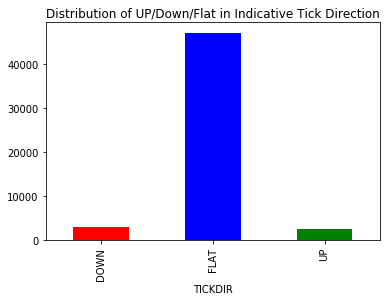

In [24]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Visualize the frequency distribution of the bid ask imbalance

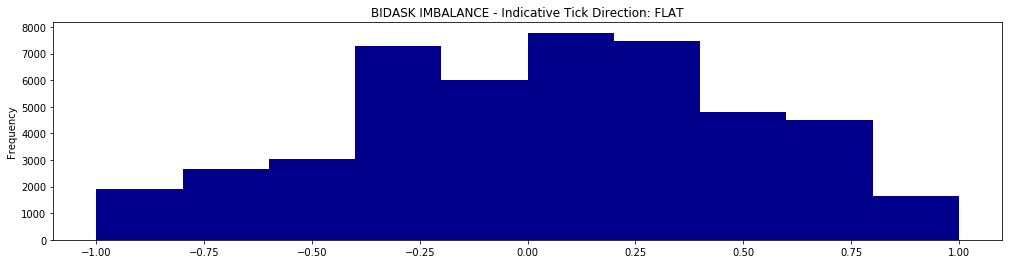

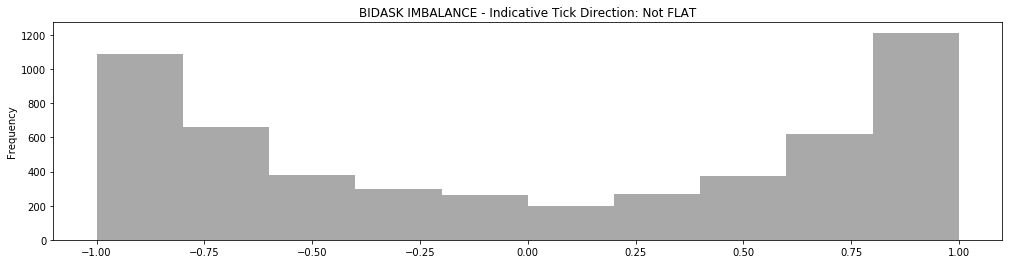

In [34]:
subset = inputData.loc[inputData['TICKDIR'] == 'FLAT']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='darkblue',
                                 title='BIDASK IMBALANCE - Indicative Tick Direction: FLAT');
plt.show()
subset = inputData.loc[inputData['TICKDIR'] != 'FLAT']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='darkGREY',
                                title='BIDASK IMBALANCE - Indicative Tick Direction: Not FLAT');
plt.show()

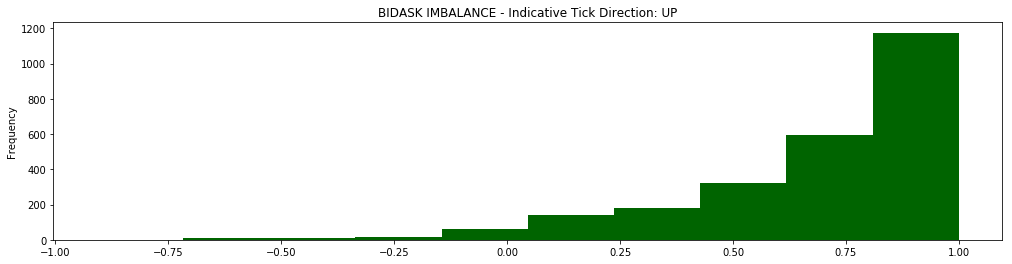

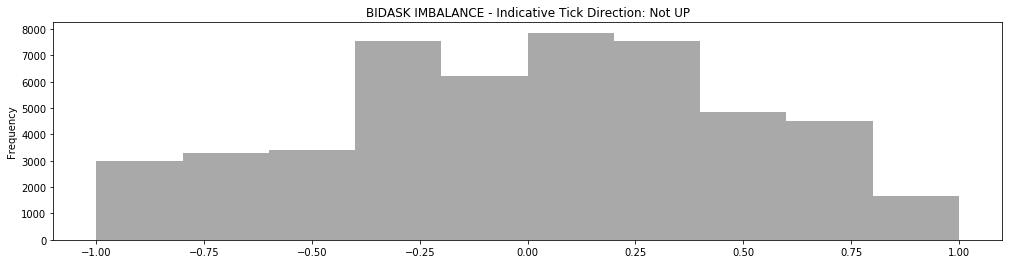

In [35]:
subset = inputData.loc[inputData['TICKDIR'] == 'UP']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='darkGREEN',
                                 title='BIDASK IMBALANCE - Indicative Tick Direction: UP');
plt.show()
subset = inputData.loc[inputData['TICKDIR'] != 'UP']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='darkGREY',
                                title='BIDASK IMBALANCE - Indicative Tick Direction: Not UP');
plt.show()

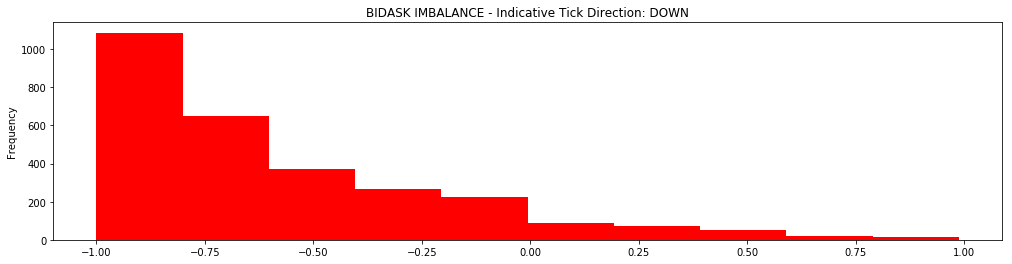

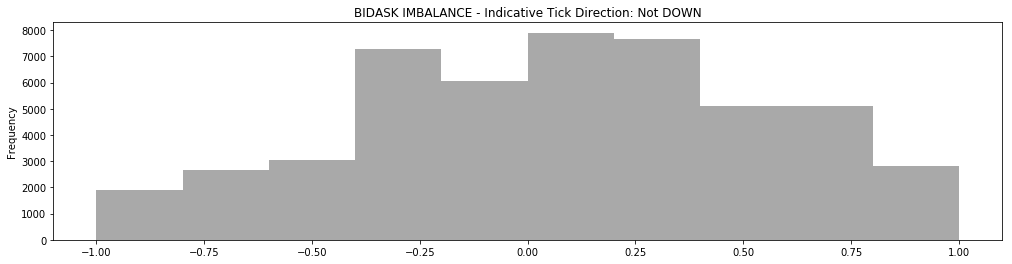

In [36]:
subset = inputData.loc[inputData['TICKDIR'] == 'DOWN']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='RED',
                                 title='BIDASK IMBALANCE - Indicative Tick Direction: DOWN');
plt.show()
subset = inputData.loc[inputData['TICKDIR'] != 'DOWN']
subset.BIDASKIMBALANCE.plot(kind='hist',figsize=(17,4), color='darkGREY',
                                title='BIDASK IMBALANCE - Indicative Tick Direction: Not DOWN');
plt.show()

#### Extract a single feature - bid ask imbalance

In [55]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [66]:
X = np.array(X).reshape(-1,1)

In [67]:
X.shape

(52396, 1)

### Binary Classification 

#### Converting the Indicative Tick Direction to numerical format

In [84]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', 0)

In [85]:
y.shape

(52396,)

#### Train test split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Classifying by Random Forest and Gradient Boosting

In [87]:
gb = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

In [88]:
y_score = gb.fit(X_train, y_train)

In [89]:
y_score = gb.predict_proba(X_test)

In [90]:
y_score = y_score[:,1]

#### ROC AUC Score and Plot

In [227]:
converted_local = [x > 0.5 for x in y_score]

In [193]:
converted_local[0:5]

[False, True, False, True, True]

In [163]:
y_score[0:5]

array([0.00132809, 0.07673449, 0.00134022, 0.10151665, 0.03491954])

In [158]:
converted_local = y_score

In [228]:
roc_auc_score(y_test, converted_local)

0.6345300151936537

In [229]:
converted_dummies = pd.get_dummies(converted_local)

In [230]:
converted_dummies.shape

(5240, 2)

In [231]:
y_test_dummies = pd.get_dummies(y_test)
y_test_dummies.shape

(5240, 2)

In [232]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[i], converted_dummies[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

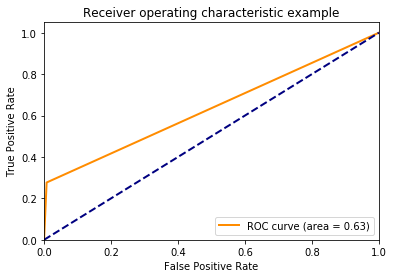

In [233]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Accuracy Score and Precision-recall Curve

In [99]:
y_pred = gb.predict(X_test)

In [100]:
accuracy_score(y_test, y_pred)

0.957824427480916

In [234]:
converted_local = [x > 0.05 for x in y_score]

In [235]:
accuracy_score(y_test, converted_local)

0.8446564885496183

In [104]:
y_score = gb.predict_proba(X_test)
y_score = y_score[:,1]

In [125]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.49


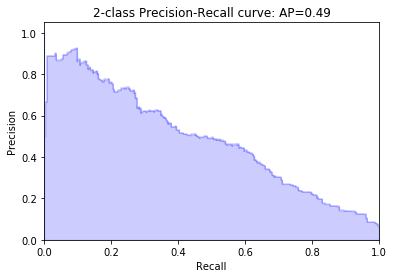

In [126]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

In [138]:
converted_local = [x > 0.25 for x in y_score]

In [139]:
average_precision = average_precision_score(y_test, converted_local)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.27


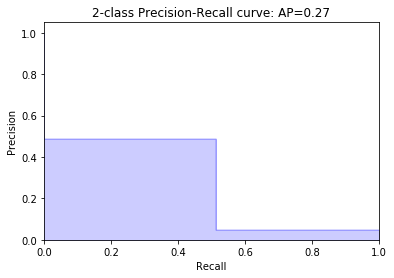

In [140]:
precision, recall, _ = precision_recall_curve(y_test, converted_local)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

#### Confusion Matrix

In [211]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [213]:
confusion_matrix(y_test, y_pred)

array([[4949,   38],
       [ 183,   70]])

In [240]:
converted_local = [x > 0.5 for x in y_score]

In [241]:
confusion_matrix(y_test, converted_local)

array([[4949,   38],
       [ 183,   70]])